# INSTAGRAM: DETECCIÓN DE USUARIOS FALSOS

## **Entrenamiento y evaluación de modelos**

<img src="https://miracomohacerlo.com/wp-content/uploads/2019/02/como-ver-a-que-fotos-le-da-like-en-instagram-una-persona-2.jpg" />

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import HTML, display
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn_pandas import DataFrameMapper

## **DATASET**

In [3]:
dataset_original = pd.read_csv('instagram.csv')
dataset = dataset_original

renamed_columns = {'pos':'post','flw':'followers','flg':'following','bl':'biography_lenght','pic':'profile_picture','lin':'external_url','cl':'post_lenght','cz':'post_lenght_null','ni':'none_image','erl':'engagement_rate_likes','erc':'engagement_rate_comments','lt':'post_location','hc':'hashtags_post','pr':'hashtags_promotional','fo':'hashtags_followers','cs':'cosine_similarity','pi':'interval_post','class':'user_class'}
dataset.rename(columns = renamed_columns, inplace = True)

dataset["user_class"] = dataset.user_class.replace(['f','r'], [0, 1])

### **Train, Validation, Test**

In [4]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(dataset, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)

## **MÉTRICAS**

1) Se debe elegir y definir una **métrica de performance** a utilizar para **evaluar los modelos**. Fundamentar la elección de la métrica.


Elegimos la métrica **Precision** ya que al momento de predecir queremos estar seguros de que una cuenta falsa realmente lo sea. No nos daría lo mismo que el modelo prediga que una cuenta es falsa si no lo es a que prediga que es verdadera cuando en realidad es falsa. Nos interesa saber del total de cuentas falsas predichas cuales realmente lo fueron. 
Bajo este sustento no podríamos utilizar **Acurracy** porque tiene diferente impacto errar en la predicción de una clase u otra. A su vez creemos que tampoco nos parece adecuado utilizar **Recall** porque se le estaría dando un tratamiento inapropiado a cuentas que se clasificaron como falsas pero que en realidad eran verdaderas. 

Si bien a continuación vamos a evaluar los modelos con todas las métricas, le vamos a dar mas importancia a Precision. 


2) Se debe aplicar alguna **técnica de feature engineering** para mejorar la data de entrada a los modelos, y mostrar la comparativa de los resultados obtenidos en cada caso. Si no es posible o útil, fundamentar el motivo por el cual no se realizará.

## FEATURE ENGINEERING

### Binning: 
Utilizamos la técnica de redondeo para las siguientes variables:
- post
- followers
- followings
- biography_lenght
- post_lenght
- engagement_rate_likes
- engagement_rate_comments
- hashtags_post
- hashtags_promotional
- hashtags_followers
- interval_post

### One-hotEnconder:
Generamos nuevas columnas a partir de las siguientes variables:
- Profile_picture
- External_URL

Consideramos que las siguientes variables no necesitan una transformación ya que contienen valores que corresponden a porcentajes entre 0 y 1:
- post_lenght_null
- none_image
- post_location
- cosine_similarity

### **MAPPER**

In [5]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [6]:
mapper = DataFrameMapper([
    (['post'], [StandardScaler()]),
    (['followers'], [StandardScaler()]),
    (['following'], [StandardScaler()]),
    (['biography_lenght'], [StandardScaler()]),
    (['profile_picture'], [OneHotEncoder()]),
    (['external_url'], [OneHotEncoder()]),
    (['post_lenght'], [StandardScaler()]),
    (['post_lenght_null'], None),
    (['none_image'], None),
    (['engagement_rate_likes'], [StandardScaler()]),
    (['engagement_rate_comments'], [StandardScaler()]),
    (['post_location'], None),
    (['hashtags_post'], [StandardScaler()]),
    (['hashtags_promotional'], [StandardScaler()]),
    (['hashtags_followers'], [StandardScaler()]),
    (['cosine_similarity'], None),
    (['interval_post'], [StandardScaler()])
])

mapper.fit(train)
mapper.transform(train)

array([[-0.24135603,  0.01445213,  0.22917829, ..., -0.11913474,
         0.25045601, -0.13909214],
       [-0.19789972,  0.71921644, -0.66507231, ...,  0.01257652,
         0.264788  ,  0.06098194],
       [-0.26710793, -0.01969895, -0.70403664, ..., -0.11913474,
         0.033352  , -0.18214522],
       ...,
       [ 1.3359474 , -0.00811533, -0.19518567, ..., -0.11913474,
         0.080069  , -0.30955051],
       [-0.2735459 , -0.04552781, -0.88959943, ..., -0.11913474,
         1.        , -0.5223442 ],
       [-0.24779401, -0.02835856, -0.07945004, ..., -0.11913474,
         0.15286601, -0.24447756]])

In [7]:
mapper.transformed_names_

['post',
 'followers',
 'following',
 'biography_lenght',
 'profile_picture_x0_0',
 'profile_picture_x0_1',
 'external_url_x0_0',
 'external_url_x0_1',
 'post_lenght',
 'post_lenght_null',
 'none_image',
 'engagement_rate_likes',
 'engagement_rate_comments',
 'post_location',
 'hashtags_post',
 'hashtags_promotional',
 'hashtags_followers',
 'cosine_similarity',
 'interval_post']

3) Por cada modelo, se debe **entrenarlo y evaluar** su comportamiento con la **métrica** elegida. Sacar conclusiones respecto a los motivos por los cuales el modelo funciona bien o mal.

## **MODELOS**

### **Función para evaluar modelos**

In [8]:
from sklearn import metrics

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import Pipeline

In [9]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=True):
    if title:
        display(title)
        
    final_metrics = defaultdict(list)
    
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]  # <- hack feo...

        y = set_data.user_class
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['real', 'fake'])
            ax.yaxis.set_ticklabels(['real', 'fake'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

### **REGRESIÓN LOGÍSTICA**

In [106]:
from sklearn.linear_model import LogisticRegression

,Accuracy,Precision,Recall,F1
train,0.811149,0.800218,0.827512,0.813636
validation,0.808726,0.791716,0.828371,0.809629


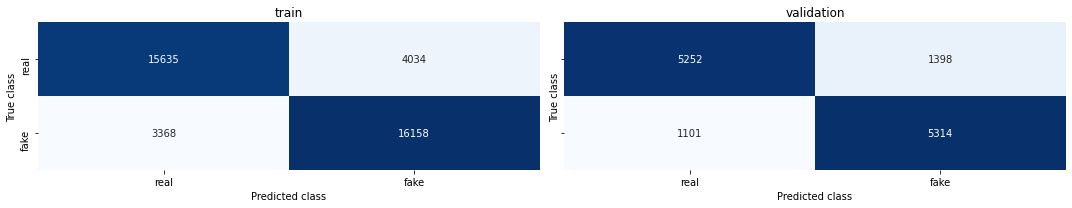

In [107]:
model_lr = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', LogisticRegression(random_state=42)),
])

model_lr.fit(train, train.user_class)

evaluate_model(model_lr)

Podemos observar que **en validation obtivimos un 80% de acierto con la métrica precision al clasificar cuentas falsas.** A su vez observamos que si bien es muy poca la diferencia de los casos reales que erró con los casos falsos que erró, esta última resulta mayor. 

#### Importancias de variables

<AxesSubplot:xlabel='coeficiente', ylabel='feature'>

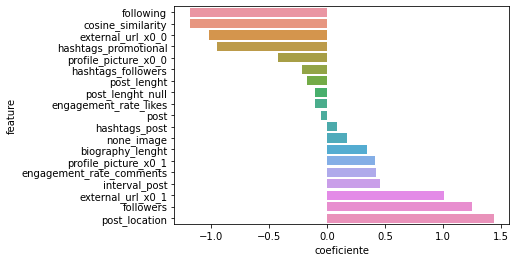

In [12]:
clf = model_lr.named_steps['classifier']
clf.coef_  # los pesos que aprendió la regresión logística!

df_importance = pd.DataFrame({
    'feature': mapper.transformed_names_, 
    'coeficiente': clf.coef_[0],
}).sort_values(by='coeficiente')

sns.barplot(data=df_importance, x='coeficiente', y='feature')

**Conclusiones:**
- Cuanto mas cantidad de following tenga un cuenta, mas probabilidades tiene de ser falsa. 
- Cuanto mas cantidad de uso de hashtags promocionales tenga una cuenta, mas probabilidades tiene de ser falsa. 
- Cuanto mas porcentaje de publicaciones con ubicación tenga una cuenta, mas probabilidades tiene de ser real. 
- Si la variable external_URL es 0, mas probabilidades hay de que la cuenta sea falsa. En cambio si es 1 de que sea real.


### **K NEAREST NEIGHBORS**

In [108]:
from sklearn.neighbors import KNeighborsClassifier

'Knn'

,Accuracy,Precision,Recall,F1
train,0.852226,0.839883,0.869046,0.854216
validation,0.826636,0.808413,0.847857,0.827665


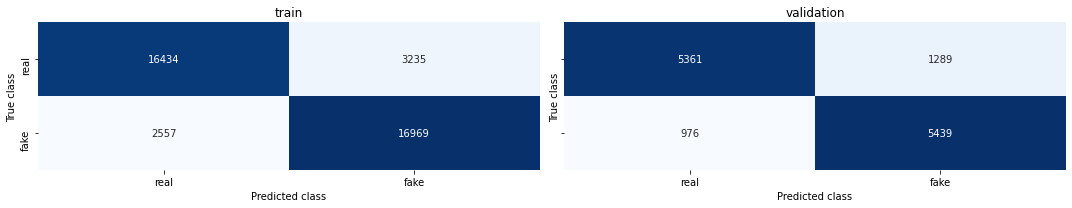

In [109]:
K = 10

model_knn = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

model_knn.fit(train, train.user_class)

evaluate_model(model_knn, title='Knn')

Observamos que en validation obtivimos un **84% de acierto** en Train y en Validation **81%**

### **ÁRBOLES DE DECISIÓN**

In [110]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,1.000000,1.000000,1.000000,1.000000
validation,0.853655,0.852072,0.849415,0.850742


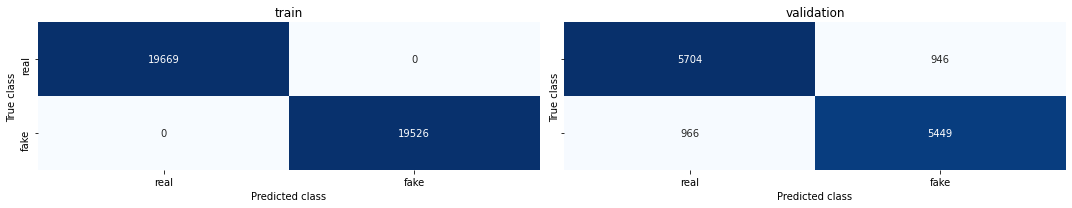

In [111]:
model_tree = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42)),
])

model_tree.fit(train, train.user_class)

evaluate_model(model_tree, title='Decision Tree')

Podemos observar que **en train el algorítmo aciertó casi todos los casos**. Sin embargo en validation observamos que si tuvo fallas a la hora de predecir por lo que entendemos que en train está haciendo **overfiting.** 

Por lo cual agregamos un valor de máxima profundidad: 

'Decision Tree'

,Accuracy,Precision,Recall,F1
train,0.906544,0.863947,0.964253,0.911348
validation,0.885036,0.841133,0.944193,0.889689


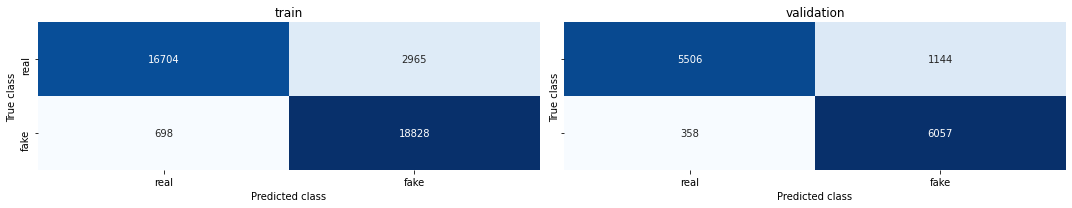

In [112]:
model_tree_maxdepth = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth = 10, random_state=42)),
])

model_tree_maxdepth.fit(train, train.user_class)

evaluate_model(model_tree_maxdepth, title='Decision Tree')

Agregando un límite de profundidad obtuvimos mejores resultados con **84% de precision** en train

### **RANDOM FOREST**

In [113]:
from sklearn.ensemble import RandomForestClassifier

'Random Forest'

,Accuracy,Precision,Recall,F1
train,1.000000,1.000000,1.000000,1.000000
validation,0.897053,0.854744,0.952143,0.900819


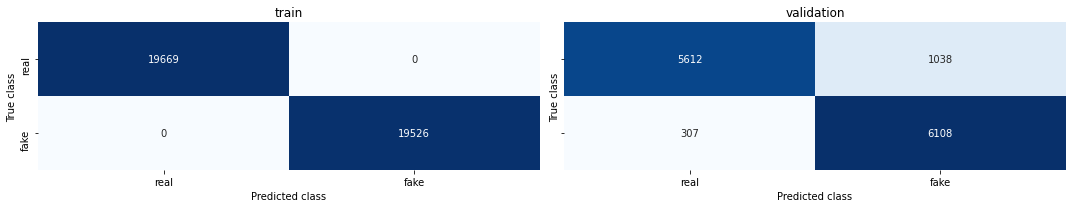

In [114]:
forest_model = RandomForestClassifier(random_state=42)

model_rf = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model),
])

model_rf.fit(train, train.user_class)

evaluate_model(model_rf, title='Random Forest')

Observamos que al no indicar un límite de profundidad y cantidad de estimadores obtenemos una precisión de 1, por lo que entendemos que el algorítmo **está sobreentrenando.** 

'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.910856,0.853377,0.991396,0.917223
validation,0.892767,0.834534,0.974903,0.899274


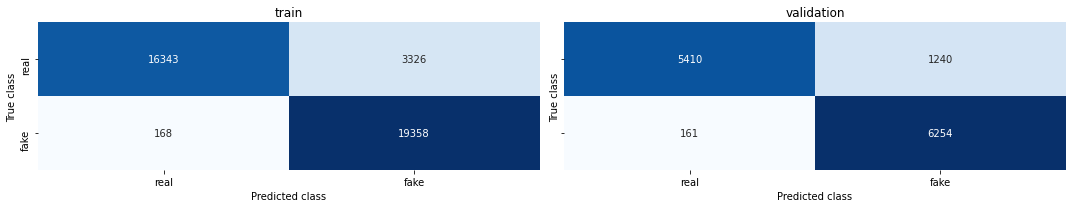

In [115]:
forest_model_maxdepth = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=5, random_state=42)

model_rf_maxdepth = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model_maxdepth),
])

model_rf_maxdepth.fit(train, train.user_class)

evaluate_model(model_rf_maxdepth, title='Random Forest')


Observamos que, para un valor de **100 arboles** y un **limite de profudidad de 10,** obtenemos un **85% de precisión** en Train y un **83%** en Validation. 


### **GRADIENT BOOSTED TREES**

In [116]:
from sklearn.ensemble import GradientBoostingClassifier

'Gradient Boosting'

,Accuracy,Precision,Recall,F1
train,0.902539,0.859438,0.961641,0.907671
validation,0.896441,0.851625,0.955573,0.900610


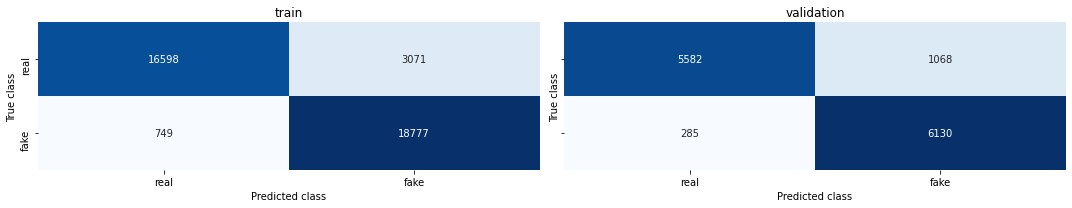

In [117]:
boost_model = GradientBoostingClassifier(random_state=42)

model_gradient_boosted = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', boost_model),
])

model_gradient_boosted.fit(train, train.user_class)

evaluate_model(model_gradient_boosted, title='Gradient Boosting')

Observamos que en validation obtivimos un **85%** en Train y **84%** en Validation. 

4) Se deben utilizar **técnicas** que garanticen que los modelos no están **sobreentrenando** sin que nos demos cuenta.

### EVITANDO OVERFITING

Tal como mencionamos anteriormente, en la evaluación de ciertos algoritmos obtuvimos una precsión del 100%, lo que nos indicaba que los algortimos estaban sobreentrenando. 
Para evitar el overfitting en estos casos indicamos: 
- Cantidad de vecinos en KNN
- Límite de profundidad en Arboles de Decision 
- Límite de profundidad en Random Forest

Ahora bien para saber cuál debería ser la cantidad de vecinos o máxima profundidad mas apropiada para indicarle a los modelos, graficamos las curvas de aprendizaje y a partir de ello seleccionamos el valor mas eficiente.


#### Curva para KNN

In [95]:
train_prec =  []
eval_prec = []
max_k = list(range(1, 21))


for k in max_k:
    
    model_knn_curva = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', KNeighborsClassifier(n_neighbors=k)),
    ])
    
    
    knn=model_knn_curva    
    knn=knn.fit(train, train.user_class)    
    train_prec.append(knn.score(train, train.user_class))
    print(knn.score(train, train.user_class))
    eval_prec.append(knn.score(validation, validation.user_class))

# graficar los resultados.
plt.plot(max_k, train_prec, color='r', label='Train')
plt.plot(max_k, eval_prec, color='b', label='Validation')
plt.title('Grafico KNN')
plt.legend()
plt.ylabel('precision')
plt.xlabel('cant de nodos')
plt.show()

KeyboardInterrupt: 

#### Curva para Arboles de decisión 

0.6836331164689373
0.8566909044520985
0.8725602755453502
0.8757239443806608
0.8843730067610664
0.8900625079729557
0.8920525577241996
0.8979206531445337
0.9016201046051793
0.9065442020665901
0.9133562954458477
0.9229238423268274
0.9332823064166348
0.9423650975889782
0.9524174001785942
0.9610409491006506
0.9695369307309606
0.9769103201939023
0.9831100905727771
0.9887485648679678


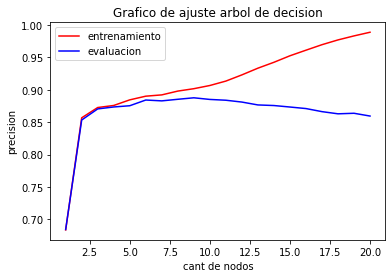

In [88]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(1, 21))


for deep in max_deep_list:
    
    model_tree_maxdepth_curva = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth = deep, random_state=42)),
    ])
    
    
    arbol_tree=model_tree_maxdepth_curva    
    arbol_tree=arbol_tree.fit(train, train.user_class)    
    train_prec.append(arbol_tree.score(train, train.user_class))
    print(arbol_tree.score(train, train.user_class))
    eval_prec.append(arbol_tree.score(validation, validation.user_class))

# graficar los resultados.
plt.plot(max_deep_list, train_prec, color='r', label='Train')
plt.plot(max_deep_list, eval_prec, color='b', label='Validation')
plt.title('Grafico arbol de decision')
plt.legend()
plt.ylabel('precision')
plt.xlabel('cant de nodos')
plt.show()

En el gráfico observamos que entre los valores 5 y 7,5 las curvas se van separando, y a su vez a partir de 10 la curva de validation comienza a caer por lo que a partir de ese momento podemos inferir que el modelo esta sobreentrenando, ya que en los casos nuevos no está acertado las predicciones. Lo que ocurre es que mientras en train va acertando cada vez mas la predicciones en validation va errando.

#### Curva para Randoom forest

0.8554917719096824
0.8694221201683888
0.8751626482969767
0.8803418803418803
0.8835820895522388
0.8878428370965684
0.8929965556831229
0.8980227069779309
0.90406939660671
0.9108559765276183
0.9187141216991963
0.9268018879959179
0.9358846791682612
0.9457328740910831
0.9560147978058425
0.9641025641025641
0.9741038397754815
0.9811710677382319
0.987115703533614
0.9922439086618191


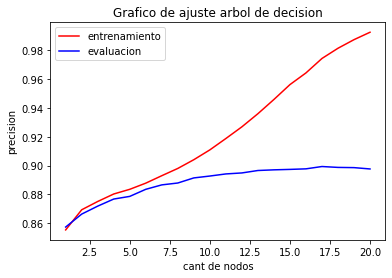

In [92]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(1, 21))


for deep in max_deep_list:
    
    forest_model_maxdepth_curva = RandomForestClassifier(n_estimators=100, max_depth=deep, max_features=5, random_state=42)

    model_rf_maxdepth_curva = Pipeline([
    ('mapper', mapper),
    ('imputer', IterativeImputer(random_state=42)),
    ('classifier', forest_model_maxdepth_curva),
    ])
    
    
    arbol_rf=model_rf_maxdepth_curva    
    arbol_rf=arbol_rf.fit(train, train.user_class)    
    train_prec.append(arbol_rf.score(train, train.user_class))
    print(arbol_rf.score(train, train.user_class))
    eval_prec.append(arbol_rf.score(validation, validation.user_class))

# graficar los resultados.
plt.plot(max_deep_list, train_prec, color='r', label='Train')
plt.plot(max_deep_list, eval_prec, color='b', label='Validation')
plt.title('Grafico Random Forest')
plt.legend()
plt.ylabel('precision')
plt.xlabel('cant de nodos')
plt.show()

A medida que avanzan las iteraciones, observamos que la métrica en validation no mejora. A partir del valor 10 aproximadamente la curva se estanca.

5) Determinar el valor final de la **métrica** que podría ser informado al cliente, utilizando técnicas que permitan obtener un valor lo más realista posible. Fundamentar.

### EVALUACIÓN FINAL DE MODELOS

In [118]:
evaluate_model(model_lr, title='Regresión Logística', set_names=('train', 'validation','test'), show_cm=False)
evaluate_model(model_knn, title='KNN', set_names=('train', 'validation','test'), show_cm=False)
evaluate_model(model_tree_maxdepth, title='Arbol de decisión', set_names=('train', 'validation','test'), show_cm=False)
evaluate_model(model_rf_maxdepth, title='Random Forest', set_names=('train', 'validation','test'), show_cm=False)
evaluate_model(model_gradient_boosted, title='Gradient Boosting', set_names=('train', 'validation','test'), show_cm=False)


'Regresión Logística'

,Accuracy,Precision,Recall,F1
train,0.811149,0.800218,0.827512,0.813636
validation,0.808726,0.791716,0.828371,0.809629
test,0.806138,0.794126,0.825433,0.809477


'KNN'

,Accuracy,Precision,Recall,F1
train,0.852226,0.839883,0.869046,0.854216
validation,0.826636,0.808413,0.847857,0.827665
test,0.821828,0.813088,0.834791,0.823797


'Arbol de decisión'

,Accuracy,Precision,Recall,F1
train,0.906544,0.863947,0.964253,0.911348
validation,0.885036,0.841133,0.944193,0.889689
test,0.888795,0.846796,0.948765,0.894885


'Random Forest'

,Accuracy,Precision,Recall,F1
train,0.910856,0.853377,0.991396,0.917223
validation,0.892767,0.834534,0.974903,0.899274
test,0.896066,0.840301,0.977451,0.903702


'Gradient Boosting'

,Accuracy,Precision,Recall,F1
train,0.902539,0.859438,0.961641,0.907671
validation,0.896441,0.851625,0.955573,0.900610
test,0.896831,0.854130,0.956588,0.902460


**Modelo elegido: Gradient Boosting**

**Precision: 85%**

### Conclusión final

Observando los resultados de las métricas para los modelos Regresion Logística, KNN y Arboles de decision, obtenemos que el mejor resultado para Precision es Arboles de Decisión ya que arroja un 84%. 

Por otro lado, comparando los resultados de todos los modelos, concluimos que **Arboles de decision, Random Forest y Gradient Boosting poseen resultados muy cercanos**, el mejor valor de precisión es el que devuelve **Gradient Boosting con 84%** por lo que es el modelo elegido.
